# Dhruv Rana
# Programming Exercise \#4
---

# Preamble

In [1]:
# optional code cell when using Google Colab with Google Drive

# remove the docstring comment block below in order to mount Google Drive
'''
# mount Google Drive in Google Colab
from google.colab import drive
drive.mount('/content/drive')

# change directory using the magic command %cd
### replace [MY PATH] below with your own path in Google Drive ###
### %cd /content/drive/My\ Drive/[MY PATH] ###
'''

"\n# mount Google Drive in Google Colab\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\n# change directory using the magic command %cd\n### replace [MY PATH] below with your own path in Google Drive ###\n### %cd /content/drive/My\\ Drive/[MY PATH] ###\n"

In [2]:
# import relevant Python libraries
import numpy as np
import pandas as pd
import math
from scipy import stats as sps
from matplotlib import colors
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Latex

# **1. Machine Learning for Diagnosis of 'Senioritis'**

## Problem 1.1

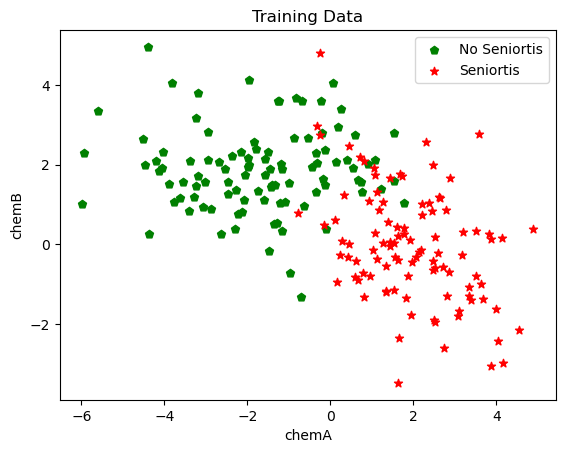

In [3]:
train_df = pd.read_csv("SenioritisTrainingData.csv")

classes = train_df["ClassLabel"].unique()

train_No_Seniortis_Features = train_df.loc[train_df["ClassLabel"] == classes[0],["ChemA","ChemB"]].to_numpy()
train_Seniortis_Features = train_df.loc[train_df["ClassLabel"] == classes[1],["ChemA","ChemB"]].to_numpy()

plt.figure()
plt.scatter(train_No_Seniortis_Features[:,0], train_No_Seniortis_Features[:,1], c="green",label="No Seniortis",marker="p")
plt.scatter(train_Seniortis_Features[:,0], train_Seniortis_Features[:,1], c="red", label ="Seniortis",marker="*")
plt.legend()
plt.title("Training Data")
plt.xlabel("chemA")
plt.ylabel("chemB")
plt.show()

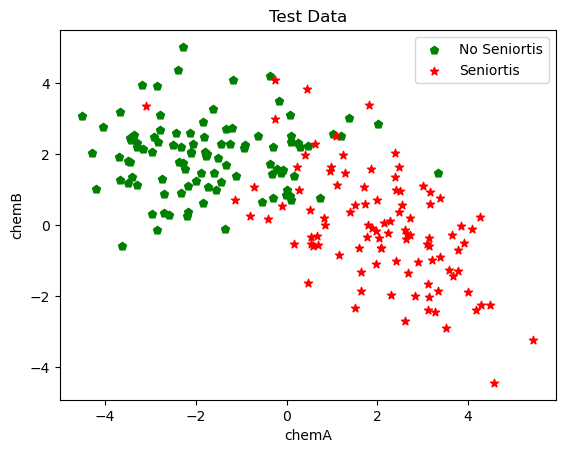

In [4]:
test_df = pd.read_csv("SenioritisTestData.csv")

classes = test_df["ClassLabel"].unique()


test_No_Seniortis_Features = test_df.loc[test_df["ClassLabel"] == classes[0],["ChemA","ChemB"]].to_numpy()
test_Seniortis_Features = test_df.loc[test_df["ClassLabel"] == classes[1],["ChemA","ChemB"]].to_numpy()

plt.figure()
plt.scatter(test_No_Seniortis_Features[:,0], test_No_Seniortis_Features[:,1], c="green",label="No Seniortis",marker="p")
plt.scatter(test_Seniortis_Features[:,0], test_Seniortis_Features[:,1], c="red", label ="Seniortis",marker="*")
plt.legend()
plt.title("Test Data")
plt.xlabel("chemA")
plt.ylabel("chemB")
plt.show()

## Problem 1.2

In [5]:
#### Functions to get necessary values for each Classifier ######

def mean_per_class(df : pd.DataFrame , label : str):
    classes = df[label].unique()
    
    mean = np.zeros_like(classes)
    
    for i in range(len(classes)):
        mean[i] = {classes[i] : df.where(df[label] == classes[i]).mean(numeric_only=True)}
    
    return mean

def cov_per_class(df : pd.DataFrame , label : str):  
    classes = df[label].unique()
    
    covariance = np.zeros_like(classes)
    
    for i in range(len(classes)):
        covariance[i] = {classes[i] : df.where(df[label] == classes[i]).cov(numeric_only=True)}
    
    return covariance


def covariance(df : pd.DataFrame , label : str):
    copy_df = df.copy()
    
    copy_df.drop([label],axis=1)
    
    covariance = copy_df.cov(numeric_only=True).to_numpy().reshape(len(classes),len(classes))
    
    return covariance

def var_per_class(df : pd.DataFrame , label : str):
    classes = df[label].unique()
    
    variance = np.zeros_like(classes)
    
    for i in range(len(classes)):
        variance[i] = {classes[i] : df.where(df[label] == classes[i]).var(numeric_only=True)}
    
    return variance

def prior(df : pd.DataFrame , label : str):
    classes = df[label].unique()
    
    prior = np.zeros_like(classes)
    
    for i in range(len(classes)):
        prior[i] = {classes[i] : df[label].value_counts()[classes[i]]/len(train_df)}
    
    return prior

In [6]:
mean_l = mean_per_class(train_df,"ClassLabel")
cov_l = cov_per_class(train_df,"ClassLabel")
var_l = var_per_class(train_df,"ClassLabel")
prior_l = prior(train_df,"ClassLabel")
cov = covariance(train_df,"ClassLabel")

### (a)

In [7]:
##### LDA ########
def LDA(X:np.array,classes,mean=mean_l,cov=cov,prior=prior_l):
    
    score = np.zeros_like(classes)
    
    for l in range(len(mean_l)):
        
        m = mean[l][classes[l]]
        c_inv = np.linalg.inv(cov)
        p = prior[l][classes[l]]
        
        score[l] = np.matmul(np.transpose(X),np.matmul(c_inv,m)) - 1/2*np.matmul(np.transpose(m),np.matmul(c_inv,m)) + math.log(p)
    
    
    return {np.argmax(score):classes[np.argmax(score)]}

### (b)

In [8]:
######## QDA #################
def QDA(X:np.array,classes,mean=mean_l,cov=cov_l,prior=prior_l):
    score = np.zeros_like(classes)
    
    for l in range(len(mean_l)):
        
        m = mean[l][classes[l]]
        c = cov[l][classes[l]]
        c_inv = np.linalg.inv(cov[l][classes[l]])
        p = prior[l][classes[l]]
        
        score[l] =  -1/2*np.matmul(np.transpose(X),np.matmul(c_inv,X)) + np.matmul(np.transpose(X),np.matmul(c_inv,m)) - 1/2*np.matmul(np.transpose(m),np.matmul(c_inv,m)) -1/2*math.log(np.linalg.det(c)) + math.log(p)
    
    return {np.argmax(score):classes[np.argmax(score)]}

### (c)

In [9]:
cov_l_naive = np.array([np.diag(np.diag(cov_l[i][classes[i]]))for i in range(len(classes))])
cov_l_naive = np.array([{classes[i]:cov_l_naive[i]}for i in range(len(classes))])

def GNB(X,classes,mean=mean_l,cov=cov_l_naive,prior=prior_l):
    
    score = np.zeros_like(classes)
    
    for l in range(len(mean_l)):
        m = mean[l][classes[l]]
        c = cov[l][classes[l]] 
        c_inv = np.linalg.inv(c)
        p = prior[l][classes[l]]
        
        score[l] =  1/(math.pow(2*math.pi,len(mean_l)/2)*np.sqrt(np.linalg.det(c))) * math.exp(-1/2*np.matmul((X-m).T,np.matmul(c_inv,(X-m)))) * p
    
    return {np.argmax(score):classes[np.argmax(score)]}

### (d)

In [10]:
def distance (feature,sample): ## can be used to cahnge the distance formula used (Using L2 norm or  Euclidean distance)
    return np.linalg.norm(feature-sample,ord=2)

########## K-Nearest Neighbour ####################
def K_NN(X, k , df : pd.DataFrame, class_label : str):
    
    classes = list(df[class_label].unique())
    label = df[class_label].to_numpy()
    features = df.drop([class_label],axis=1).to_numpy()
    
    distances = np.zeros_like(label)
    
    for i in range(len(label)):
        distances[i] = distance(features[i],X)
    
    K_nearest_label = label[np.argsort(distances)[0:k]]
    
    K_df = pd.DataFrame(K_nearest_label)
    
    most_frequnet_label = K_df.mode().to_numpy()[0] 

    if(len(most_frequnet_label) != 1): # resolve ties
        most_frequnet_label = most_frequnet_label[math.floor(np.random.randint(low=0,high=len(most_frequnet_label)))]
    
    return {classes.index(most_frequnet_label):most_frequnet_label}

## Problem 1.3

In [11]:
true_label = test_df["ClassLabel"].to_numpy()
features = test_df.drop(["ClassLabel"],axis=1).to_numpy()

LDA_label = np.zeros_like(true_label)
QDA_label = np.zeros_like(true_label)
GNB_label = np.zeros_like(true_label)
KNN_label = np.zeros_like(true_label)

for i in range(len(true_label)):
    LDA_label[i] = list(LDA(features[i],classes).values())[0]
    QDA_label[i] = list(QDA(features[i],classes).values())[0]
    GNB_label[i] = list(GNB(features[i],classes).values())[0]
    KNN_label[i] = list(K_NN(features[i],3,train_df,"ClassLabel").values())[0]

# Only for binary classification
def confusionMatrix(true_label,pred_label,LABELS):

    matrix = np.zeros((len(LABELS),len(LABELS)))
    
    for i in range(len(true_label)):
        
        true_index = list(LABELS).index(true_label[i])
        pred_index = list(LABELS).index(pred_label[i])

        matrix[true_index][pred_index] = matrix[true_index][pred_index] + 1

    return matrix


LDA_cf_matrix = confusionMatrix(true_label,LDA_label,classes)
QDA_cf_matrix = confusionMatrix(true_label,QDA_label,classes)
GNB_cf_matrix = confusionMatrix(true_label,GNB_label,classes)
KNN_cf_matrix = confusionMatrix(true_label,KNN_label,classes)

###############################################
#              \ Predicted Label              # 
#     True Label_|__No Senioritis__Senioritis #
#  No Senioritis |       TN            FP     #
#     Senioritis |       FN            TP     #
###############################################

# P = FN + TP
# N = TN + FP
# misclassification: F = FN + FP
# accurate: T = TN + TP


In [12]:
pos_idx = list(classes).index("Senioritis")
neg_idx = list(classes).index("No Senioritis")

### (a)

In [13]:
### Your code for 1.3(a) goes here ###
LDA_missclasification = (LDA_cf_matrix[pos_idx][neg_idx] + LDA_cf_matrix[neg_idx][pos_idx])/(len(test_df)) * 100
QDA_missclasification = (QDA_cf_matrix[pos_idx][neg_idx] + QDA_cf_matrix[neg_idx][pos_idx])/(len(test_df)) * 100
GNB_missclasification = (GNB_cf_matrix[pos_idx][neg_idx] + GNB_cf_matrix[neg_idx][pos_idx])/(len(test_df)) * 100
KNN_missclasification = (KNN_cf_matrix[pos_idx][neg_idx] + KNN_cf_matrix[neg_idx][pos_idx])/(len(test_df)) * 100


performance = pd.DataFrame([LDA_missclasification,QDA_missclasification,GNB_missclasification,KNN_missclasification],columns=["Prob. of Misclassification"],index=["Linear Discriminant Analysis (LDA)","Quadratic Discriminant Analysis (QDA)","Gaussian Naive Bayes (GNB)","K-Nearest Neighbor (K-NN)"])

print(performance.to_markdown())

|                                       |   Prob. of Misclassification |
|:--------------------------------------|-----------------------------:|
| Linear Discriminant Analysis (LDA)    |                          8.5 |
| Quadratic Discriminant Analysis (QDA) |                          9   |
| Gaussian Naive Bayes (GNB)            |                          8.5 |
| K-Nearest Neighbor (K-NN)             |                          9.5 |


### (b)

In [14]:
### Your code for 1.3(b) goes here ###
P = test_df["ClassLabel"].value_counts()[pos_idx]

LDA_TP = LDA_cf_matrix[pos_idx][pos_idx]
QDA_TP = QDA_cf_matrix[pos_idx][pos_idx]
GNB_TP = GNB_cf_matrix[pos_idx][pos_idx]
KNN_TP = KNN_cf_matrix[pos_idx][pos_idx]

LDA_TPR = LDA_TP/P * 100
QDA_TPR = QDA_TP/P * 100
GNB_TPR = GNB_TP/P * 100
KNN_TPR = KNN_TP/P * 100

performance["TPR"] = [LDA_TPR,QDA_TPR,GNB_TPR,KNN_TPR]

print(performance.to_markdown())

|                                       |   Prob. of Misclassification |   TPR |
|:--------------------------------------|-----------------------------:|------:|
| Linear Discriminant Analysis (LDA)    |                          8.5 |    89 |
| Quadratic Discriminant Analysis (QDA) |                          9   |    88 |
| Gaussian Naive Bayes (GNB)            |                          8.5 |    86 |
| K-Nearest Neighbor (K-NN)             |                          9.5 |    91 |


### (c)

In [15]:
N = test_df["ClassLabel"].value_counts()[neg_idx]

LDA_FP = LDA_cf_matrix[neg_idx][pos_idx]
QDA_FP = QDA_cf_matrix[neg_idx][pos_idx]
GNB_FP = GNB_cf_matrix[neg_idx][pos_idx]
KNN_FP = KNN_cf_matrix[neg_idx][pos_idx]

LDA_FPR = LDA_FP/N * 100
QDA_FPR = QDA_FP/N * 100 
GNB_FPR = GNB_FP/N * 100 
KNN_FPR = KNN_FP/N * 100

performance["FPR"] = [LDA_FPR,QDA_FPR,GNB_FPR,KNN_FPR]

print(performance.to_markdown())

|                                       |   Prob. of Misclassification |   TPR |   FPR |
|:--------------------------------------|-----------------------------:|------:|------:|
| Linear Discriminant Analysis (LDA)    |                          8.5 |    89 |     6 |
| Quadratic Discriminant Analysis (QDA) |                          9   |    88 |     6 |
| Gaussian Naive Bayes (GNB)            |                          8.5 |    86 |     3 |
| K-Nearest Neighbor (K-NN)             |                          9.5 |    91 |    10 |


### (d)

In [16]:
LDA_TN = LDA_cf_matrix[neg_idx][neg_idx]
QDA_TN = QDA_cf_matrix[neg_idx][neg_idx]
GNB_TN = GNB_cf_matrix[neg_idx][neg_idx]
KNN_TN = KNN_cf_matrix[neg_idx][neg_idx]

LDA_TNR = LDA_TN/N * 100
QDA_TNR = QDA_TN/N * 100
GNB_TNR = GNB_TN/N * 100
KNN_TNR = KNN_TN/N * 100

performance["TNR"] = [LDA_TNR,QDA_TNR,GNB_TNR,KNN_TNR]

print(performance.to_markdown())

|                                       |   Prob. of Misclassification |   TPR |   FPR |   TNR |
|:--------------------------------------|-----------------------------:|------:|------:|------:|
| Linear Discriminant Analysis (LDA)    |                          8.5 |    89 |     6 |    94 |
| Quadratic Discriminant Analysis (QDA) |                          9   |    88 |     6 |    94 |
| Gaussian Naive Bayes (GNB)            |                          8.5 |    86 |     3 |    97 |
| K-Nearest Neighbor (K-NN)             |                          9.5 |    91 |    10 |    90 |


### (e)

In [17]:
LDA_FN = LDA_cf_matrix[pos_idx][neg_idx]
QDA_FN = QDA_cf_matrix[pos_idx][neg_idx]
GNB_FN = GNB_cf_matrix[pos_idx][neg_idx]
KNN_FN = KNN_cf_matrix[pos_idx][neg_idx]

LDA_FNR = LDA_FN/P * 100
QDA_FNR = QDA_FN/P * 100 
GNB_FNR = GNB_FN/P * 100 
KNN_FNR = KNN_FN/P * 100

performance["FNR"] = [LDA_FNR,QDA_FNR,GNB_FNR,KNN_FNR]

print(performance.to_markdown())

|                                       |   Prob. of Misclassification |   TPR |   FPR |   TNR |   FNR |
|:--------------------------------------|-----------------------------:|------:|------:|------:|------:|
| Linear Discriminant Analysis (LDA)    |                          8.5 |    89 |     6 |    94 |    11 |
| Quadratic Discriminant Analysis (QDA) |                          9   |    88 |     6 |    94 |    12 |
| Gaussian Naive Bayes (GNB)            |                          8.5 |    86 |     3 |    97 |    14 |
| K-Nearest Neighbor (K-NN)             |                          9.5 |    91 |    10 |    90 |     9 |


In [18]:
LDA_Precision = LDA_TP/(LDA_TP + LDA_FP) * 100
QDA_Precision = QDA_TP/(QDA_TP + QDA_FP) * 100 
GNB_Precision = GNB_TP/(GNB_TP + GNB_FP) * 100 
KNN_Precision = KNN_TP/(KNN_TP + KNN_FP) * 100

performance["Precision"] = [LDA_Precision,QDA_Precision,GNB_Precision,KNN_Precision]

print(performance.to_markdown())

|                                       |   Prob. of Misclassification |   TPR |   FPR |   TNR |   FNR |   Precision |
|:--------------------------------------|-----------------------------:|------:|------:|------:|------:|------------:|
| Linear Discriminant Analysis (LDA)    |                          8.5 |    89 |     6 |    94 |    11 |     93.6842 |
| Quadratic Discriminant Analysis (QDA) |                          9   |    88 |     6 |    94 |    12 |     93.617  |
| Gaussian Naive Bayes (GNB)            |                          8.5 |    86 |     3 |    97 |    14 |     96.6292 |
| K-Nearest Neighbor (K-NN)             |                          9.5 |    91 |    10 |    90 |     9 |     90.099  |


In [19]:
LDA_Accuracy = (LDA_TN + LDA_TP)/(LDA_TP + LDA_FP + LDA_TN + LDA_FN) * 100
QDA_Accuracy = (QDA_TN + QDA_TP)/(QDA_TP + QDA_FP + QDA_TN + QDA_FN) * 100 
GNB_Accuracy = (GNB_TN + GNB_TP)/(GNB_TP + GNB_FP + GNB_TN + GNB_FN) * 100 
KNN_Accuracy = (KNN_TN + KNN_TP)/(KNN_TP + KNN_FP + KNN_TN + KNN_FN) * 100

performance["Accuracy"] = [LDA_Accuracy,QDA_Accuracy,GNB_Accuracy,KNN_Accuracy]

print(performance.to_markdown())

|                                       |   Prob. of Misclassification |   TPR |   FPR |   TNR |   FNR |   Precision |   Accuracy |
|:--------------------------------------|-----------------------------:|------:|------:|------:|------:|------------:|-----------:|
| Linear Discriminant Analysis (LDA)    |                          8.5 |    89 |     6 |    94 |    11 |     93.6842 |       91.5 |
| Quadratic Discriminant Analysis (QDA) |                          9   |    88 |     6 |    94 |    12 |     93.617  |       91   |
| Gaussian Naive Bayes (GNB)            |                          8.5 |    86 |     3 |    97 |    14 |     96.6292 |       91.5 |
| K-Nearest Neighbor (K-NN)             |                          9.5 |    91 |    10 |    90 |     9 |     90.099  |       90.5 |


In [20]:
LDA_F1_score = 2/( (1/(LDA_Precision)) + (1/(LDA_TPR)) )
QDA_F1_score = 2/( (1/(QDA_Precision)) + (1/(QDA_TPR)) )
GNB_F1_score = 2/( (1/(GNB_Precision)) + (1/(GNB_TPR)) )
KNN_F1_score = 2/( (1/(KNN_Precision)) + (1/(KNN_TPR)) )

performance["F-1 Score"] = [LDA_F1_score,QDA_F1_score,GNB_F1_score,KNN_F1_score]

print(performance.to_markdown())

|                                       |   Prob. of Misclassification |   TPR |   FPR |   TNR |   FNR |   Precision |   Accuracy |   F-1 Score |
|:--------------------------------------|-----------------------------:|------:|------:|------:|------:|------------:|-----------:|------------:|
| Linear Discriminant Analysis (LDA)    |                          8.5 |    89 |     6 |    94 |    11 |     93.6842 |       91.5 |     91.2821 |
| Quadratic Discriminant Analysis (QDA) |                          9   |    88 |     6 |    94 |    12 |     93.617  |       91   |     90.7216 |
| Gaussian Naive Bayes (GNB)            |                          8.5 |    86 |     3 |    97 |    14 |     96.6292 |       91.5 |     91.0053 |
| K-Nearest Neighbor (K-NN)             |                          9.5 |    91 |    10 |    90 |     9 |     90.099  |       90.5 |     90.5473 |


## Problem 1.4

_After making the Performance matrix for all classifiers, I would suggest using LDA as it has the highest F-1 score_

## Problem 1.5

In [21]:
color_map = colors.LinearSegmentedColormap.from_list("my cmap",("#d8f3dc","#ffddd2"),N=100)

### (a)

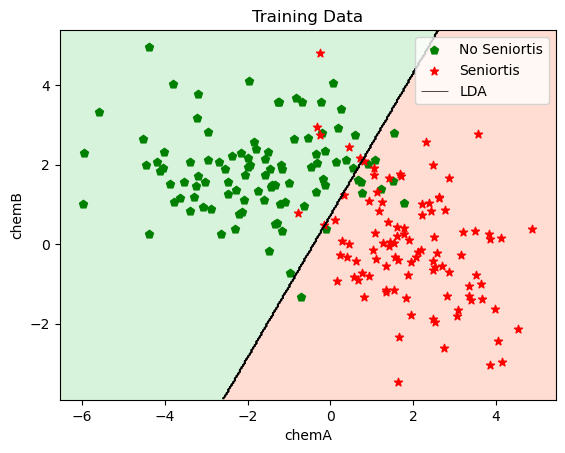

In [22]:
plt.figure()
s1 = plt.scatter(train_No_Seniortis_Features[:,0], train_No_Seniortis_Features[:,1], c="green",marker="p")
s2 = plt.scatter(train_Seniortis_Features[:,0], train_Seniortis_Features[:,1], c="red",marker="*")

nx, ny = 300, 300
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
Z = np.zeros_like(xx.ravel())

for i in range(len(Z)):
    Z[i] = list(LDA(np.c_[xx.ravel()[i], yy.ravel()[i]][0],classes))[0]
    
Z = Z.reshape(xx.shape)

plt.pcolormesh(
    xx, yy, Z, cmap=color_map, norm=colors.Normalize(0.0, 1.0), zorder=0
)

c1 = plt.contour(xx, yy, Z, linewidths=0.5, colors="black")

plt.legend([s1,s2,c1.legend_elements()[0][0]],["No Seniortis","Seniortis","LDA"])
plt.title("Training Data")
plt.xlabel("chemA")
plt.ylabel("chemB")
plt.show()

### (b)

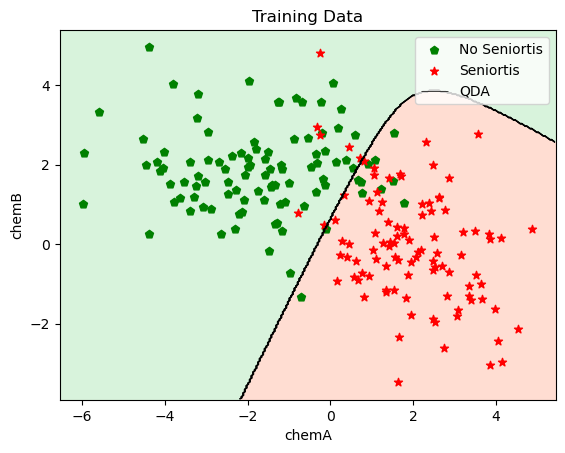

In [23]:
plt.figure()
s1 = plt.scatter(train_No_Seniortis_Features[:,0], train_No_Seniortis_Features[:,1], c="green",marker="p")
s2 = plt.scatter(train_Seniortis_Features[:,0], train_Seniortis_Features[:,1], c="red",marker="*")

nx, ny = 300, 300
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
Z = np.zeros_like(xx.ravel())

for i in range(len(Z)):
    Z[i] = list(QDA(np.c_[xx.ravel()[i], yy.ravel()[i]][0],classes))[0]
    
Z = Z.reshape(xx.shape)

plt.pcolormesh(
    xx, yy, Z, cmap=color_map, norm=colors.Normalize(0.0, 1.0), zorder=0
)

c1 = plt.contour(xx, yy, Z, linewidths=0.5, colors="black")

plt.legend([s1,s2,c1.legend_elements()[0][0]],["No Seniortis","Seniortis","QDA"])
plt.title("Training Data")
plt.xlabel("chemA")
plt.ylabel("chemB")
plt.show()

### (c)

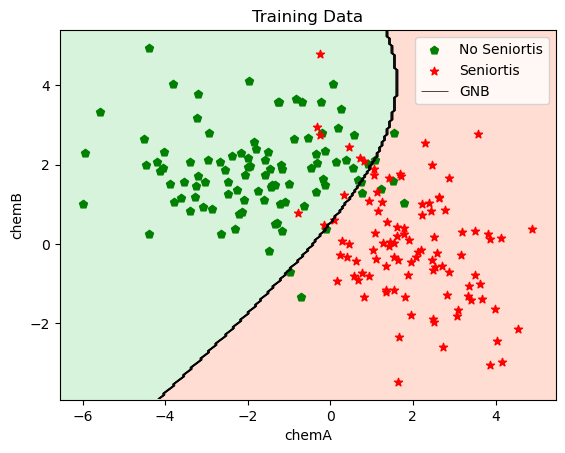

In [24]:
plt.figure()
s1 = plt.scatter(train_No_Seniortis_Features[:,0], train_No_Seniortis_Features[:,1], c="green",marker="p")
s2 = plt.scatter(train_Seniortis_Features[:,0], train_Seniortis_Features[:,1], c="red",marker="*")

nx, ny = 200, 200
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
Z = np.zeros_like(xx.ravel())

for i in range(len(Z)):
    Z[i] = list(GNB(np.c_[xx.ravel()[i], yy.ravel()[i]][0],classes))[0]
    
Z = Z.reshape(xx.shape)

plt.pcolormesh(
    xx, yy, Z, cmap=color_map, norm=colors.Normalize(0.0, 1.0), zorder=0
)

c1 = plt.contour(xx, yy, Z, linewidths=0.5, colors="black")

plt.legend([s1,s2,c1.legend_elements()[0][0]],["No Seniortis","Seniortis","GNB"])
plt.title("Training Data")
plt.xlabel("chemA")
plt.ylabel("chemB")
plt.show()

### (d)

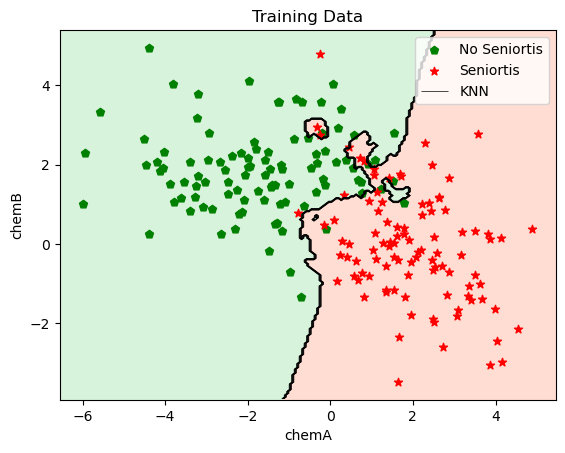

In [25]:
plt.figure()
s1 = plt.scatter(train_No_Seniortis_Features[:,0], train_No_Seniortis_Features[:,1], c="green",marker="p")
s2 = plt.scatter(train_Seniortis_Features[:,0], train_Seniortis_Features[:,1], c="red",marker="*")

nx, ny = 200, 200
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
Z = np.zeros_like(xx.ravel())

for i in range(len(Z)):
    Z[i] = list(K_NN(np.c_[xx.ravel()[i], yy.ravel()[i]][0],3,train_df,"ClassLabel"))[0]
    
Z = Z.reshape(xx.shape)

plt.pcolormesh(
    xx, yy, Z, cmap=color_map, norm=colors.Normalize(0.0, 1.0), zorder=0
)

c1 = plt.contour(xx, yy, Z, linewidths=0.5, colors="black")

plt.legend([s1,s2,c1.legend_elements()[0][0]],["No Seniortis","Seniortis","KNN"])
plt.title("Training Data")
plt.xlabel("chemA")
plt.ylabel("chemB")
plt.show()

### (e)

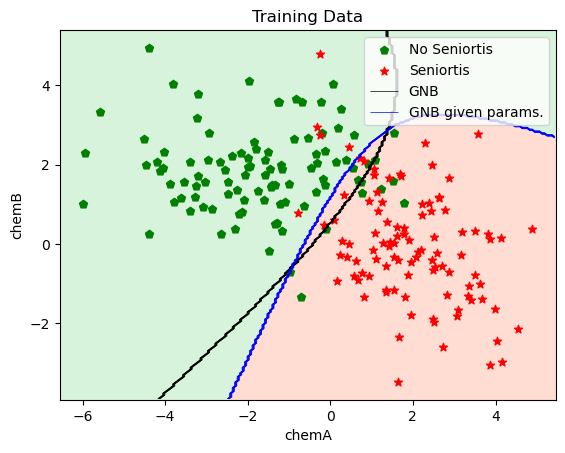

In [26]:
mean_l_e = np.array([{"No Senioritis":[-2,2]},{"Senioritis": [2,0]}])
cov_l_e = np.array([{"No Senioritis":[[3,0],[0,1]]}, {"Senioritis":[[2,-1],[-1,2]]}])

plt.figure()
s1 = plt.scatter(train_No_Seniortis_Features[:,0], train_No_Seniortis_Features[:,1], c="green",marker="p")
s2 = plt.scatter(train_Seniortis_Features[:,0], train_Seniortis_Features[:,1], c="red",marker="*")

nx, ny = 200, 200
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
Z = np.zeros_like(xx.ravel())
Z2 = np.zeros_like(xx.ravel())

for i in range(len(Z)):
    Z[i] = list(GNB(np.c_[xx.ravel()[i], yy.ravel()[i]][0],classes))[0]
    
Z = Z.reshape(xx.shape)

c1 = plt.contour(xx, yy, Z, linewidths=0.5, colors="black")

for i in range(len(Z2)):
    Z2[i] = list(GNB(np.c_[xx.ravel()[i], yy.ravel()[i]][0],classes,mean=mean_l_e,cov=cov_l_e))[0]
    
Z2 = Z2.reshape(xx.shape)

plt.pcolormesh(
    xx, yy, Z2, cmap=color_map, norm=colors.Normalize(0.0, 1.0), zorder=0
)

c2 = plt.contour(xx, yy, Z2, linewidths=0.5, colors="blue")

plt.legend([s1,s2,c1.legend_elements()[0][0],c2.legend_elements()[0][0]],["No Seniortis","Seniortis","GNB","GNB given params."])
plt.title("Training Data")
plt.xlabel("chemA")
plt.ylabel("chemB")
plt.show()

## Problem 1.6


### (a)

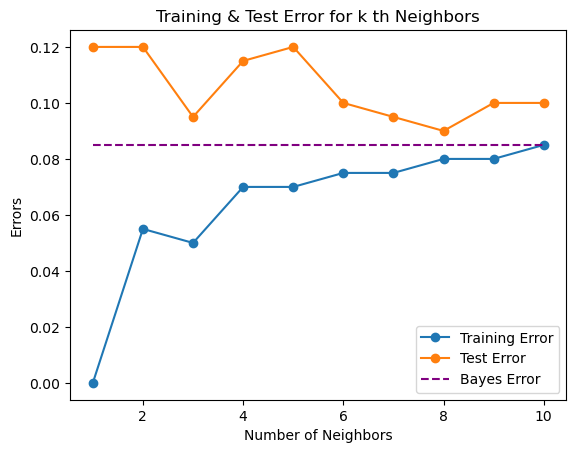

In [27]:
max_k = 10

test_error = np.zeros(max_k)
train_error = np.zeros(max_k)
k_line = np.zeros(max_k)
bayes_error = np.ones(max_k) * (GNB_missclasification / 100)

for k in range (10):
    train_true_label = train_df["ClassLabel"].to_numpy()
    train_features = train_df.drop(["ClassLabel"],axis=1).to_numpy()
    train_KNN_label = np.zeros_like(train_true_label)
    
    for i in range(len(train_df)):
        train_KNN_label[i] = list(K_NN(train_features[i],k+1,train_df,"ClassLabel").values())[0]
    
    train_KNN_cf = confusionMatrix(train_true_label,train_KNN_label,classes)
    
    train_error[k] = (train_KNN_cf[pos_idx][neg_idx] + train_KNN_cf[neg_idx][pos_idx])/(len(train_df))
    
    test_true_label = test_df["ClassLabel"].to_numpy()
    test_features = test_df.drop(["ClassLabel"],axis=1).to_numpy()
    test_KNN_label = np.zeros_like(test_true_label)
    
    for j in range(len(test_df)):
        test_KNN_label[j] = list(K_NN(test_features[j],k+1,train_df,"ClassLabel").values())[0]
    
    test_KNN_cf = confusionMatrix(test_true_label,test_KNN_label,classes)
    
    test_error[k] = (test_KNN_cf[pos_idx][neg_idx] + test_KNN_cf[neg_idx][pos_idx])/(len(test_df))
    
    k_line[k] = k+1    
    
plt.figure()
plt.plot(k_line,train_error,'-o',label="Training Error")
plt.plot(k_line,test_error,'-o',label="Test Error")
plt.plot(k_line,bayes_error,'--',label="Bayes Error",color="purple")
plt.legend()
plt.title("Training & Test Error for k th Neighbors")
plt.ylabel("Errors")
plt.xlabel("Number of Neighbors")
plt.show()    

### (b)

_If we assume our test data is for validation purposes than we would pick the k that gives us the least error, which is k = 8._